In [7]:
import hierarc
print (hierarc.__file__)

/home/chinyi/mybin/hierArc/hierarc/__init__.py


In [8]:
# some standard python imports #
import copy
import numpy as np
import corner
import emcee
import pickle
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from os.path import dirname, abspath
%matplotlib inline

# we give it a random seed to produce the identical plots
np.random.seed(seed=10)

from pylab import rc
rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)

# import the hierArc, lenstronomy and astropy classes
from hierarc.Sampling.mcmc_sampling import MCMCSampler
from astropy.cosmology import FlatLambdaCDM
from hierarc.Diagnostics.goodness_of_fit import GoodnessOfFit
from lenstronomy.Plots import plot_util
from hierarc.Util.distribution_util import PDFSampling

kwargs_corner = {'bins': 20, 'smooth': 0.7, 'smooth1d': None, 'plot_datapoints': False,
             'label_kwargs': dict(fontsize=20), 'levels': [0.68,0.95],
             'fill_contours': True, 'alpha': 0.2, 
            }

anisotropy_profile = 'OM'
save_figures=False


In [9]:
n_burn=1000

#ndim = mcmc_sampler_sdss_all.param.num_param
# Set up the backend
# Don't forget to clear it in case the file already exists
if anisotropy_profile == 'OM':
    filename = "all_lenses_chain_OM.h5"
elif anisotropy_profile == 'const':
    filename = "all_lenses_chain_const.h5"
else:
    raise Exception("Not Supported")

backend = emcee.backends.HDFBackend(filename)


mcmc_samples_sdss_all = backend.get_chain(discard=n_burn, flat=True, thin=1)
log_prob_sdss_all = backend.get_log_prob(discard=n_burn, flat=True, thin=1)
mcmc_samples_sdss_all_plot = copy.deepcopy(mcmc_samples_sdss_all)

In [10]:
len(mcmc_samples_sdss_all_plot)

mcmc_samples_sdss_all_plot = np.array([([x[0],x[2],x[3],x[1],x[4],x[5],x[6]]) for x in mcmc_samples_sdss_all_plot])
#mcmc_samples_sdss_all_plot_cut = mcmc_samples_sdss_all_plot[mcmc_samples_sdss_all_plot[:,1] <0.05]

lens SDSSJ0737+3216 does not have a file kappaSLACS/kappahist_SDSSJ0737+3216_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_oneoverr_23.0_med_increments2_2_emptymsk.cat
lens SDSSJ2300+0022 does not have a file kappaSLACS/kappahist_SDSSJ2300+0022_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_oneoverr_23.0_med_increments2_2_emptymsk.cat
lens SDSSJ2343-0030 does not have a file kappaSLACS/kappahist_SDSSJ2343-0030_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_oneoverr_23.0_med_increments2_2_emptymsk.cat
lens SL2SJ0214-0405 does not have a file kappaSLACS/kappahist_SL2SJ0214-0405_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_oneoverr_23.0_med_increments2_2_emptymsk.cat
lens SL2SJ0217-0513 does not have a file kappaSLACS/kappahist_SL2SJ0217-0513_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_oneoverr_23.0_med_increments2_2_emptymsk.cat
lens SL2SJ0219-0829 does not have a file kappaSLACS/kappahist_SL2SJ0219-0829_com

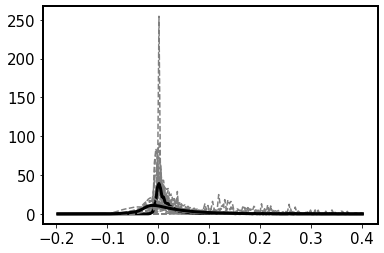

In [11]:
posterior_sdss_list = pickle.load(open("combined_slit_const_processed.pkl", "rb"))
lens_list = [x["name"] for x in posterior_sdss_list]


# we describe the population distribution of the anisotropy parameters with a GAUSSIAN.
# Available are 'GAUSSIAN' and 'NONE' (single valued distribution)
anisotropy_distribution = "GAUSSIAN"  # 'NONE' or 'GAUSSIAN'

# In this notebook, we assume a fixed cosmology to perform the inference.
# This assumption is lifted when performing the joint constraints with the TDCOSMO sample.
H0 = 70
omega_m = 0.30
cosmo_fixed = FlatLambdaCDM(H0=H0, Om0=omega_m)

blinded = False  # blinded plots in regard to lambda_int
sigma_v_systematics = True

ifu_lambda_separate = True  # boolean, if True, samples a separate lambda_mst parameter for the IFU data (assuming the callibration is not fully accurate)
lambda_slope = True  # allow for linear scaling of lambda_int with r_eff/theta_E
log_scatter = True

num_distribution_draws = 200  # numerical setting for how many samples to draw from the distribution quantities to compute the marginalized likelihood in the sampling

# this is for saving the chains under different names
if ifu_lambda_separate is True:
    model_prefix = "ifu_separate"
else:
    model_prefix = "ifu_joint"

run_chains = True  # boolean, if True, runs the chains, else uses the stored chains to do the plotting
continue_from_backend = False  # boolean, if True, continues sampling the emcee chain from a backend (if exists), otherwise deletes previous chains and starts from scratch

n_walkers = 100  # number of walkers in the EMCEE
# these settings are for shorter example runs that might not be fully converged
n_run = 2000  # number of iterations that are stored
n_burn = 0  # number of burn-in iterations not stored

# import the SLACS sample

# all SLACS lenses including those with population prior from Shajib et al. 2020 passing our selection criteria (see sample_selection notebook) (excluding the lenses with additonal IFU data)
sdss_names_all = lens_list


# the kinematic predictions and scaling with anisotropy parameters are pre-processed (see pre-processing notebook)
# and we import the pickle files containing all the relevant information for the likelihood to be evaluated with hierARc

anisotropy_model = anisotropy_profile

if anisotropy_model == "OM":
    ifu_sample_file_name = "combined_ifu_om_processed.pkl"
    sdss_sample_file_name = "combined_slit_om_processed.pkl"
elif anisotropy_model == "GOM":
    ifu_sample_file_name = "combined_ifu_gom_processed.pkl"
    sdss_sample_file_name = "combined_slit_gom_processed.pkl"
elif anisotropy_model == "const":
    ifu_sample_file_name = "combined_ifu_const_processed.pkl"
    sdss_sample_file_name = "combined_slit_const_processed.pkl"

from hierarc.Util.distribution_util import PDFSampling


names_selected = sdss_names_all

percentiles = [16, 50, 84]
quantiles = [0.16, 0.5, 0.84]
title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
fmt = "{{0:{0}}}".format(".3f").format

# option with file ending
with_shear = False  # bool, if True, adds shear constraints in LOS estimate (only available for a subset of the sample)

kappa_choice_shear_ending = "_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_gamma_120_oneoverr_23.0_med_increments2_16_2_emptymsk_shearwithoutprior.cat"
kappa_choice_no_shear_ending = "_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_oneoverr_23.0_med_increments2_2_emptymsk.cat"

#'kappahist_SDSSJ2300+0022_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_oneoverr_23.0_med_increments2_emptymsk'
#'kappahist_SDSSJ2300+0022_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_23.0_med_increments2_emptymsk.cat'

if with_shear is True:
    kappa_choice_ending = kappa_choice_shear_ending
else:
    kappa_choice_ending = kappa_choice_no_shear_ending


# kappa_bins = np.linspace(-0.05, 0.2, 50)
with open("kappaSL2S/SL2SJ0214-0405.kappa", "rb") as f:
    output = pickle.load(f)
# loop through selected lenses
kappa_bins = output["bins"]

# loop through selected lenses

kappa_pdf_tot = np.zeros(len(kappa_bins) - 1)
num_lenses = 0

for name in names_selected:
    path2kappa = os.path.join("kappaSLACS")
    filepath = os.path.join(path2kappa, "kappahist_" + name + kappa_choice_ending)

    try:
        output = np.loadtxt(filepath, delimiter=" ", skiprows=1)
        kappa_sample = output[:, 0]
        kappa_weights = output[:, 1]
        kappa_pdf, kappa_bin_edges = np.histogram(
            kappa_sample, weights=kappa_weights, bins=kappa_bins, density=True
        )  # , bins=kappa_bins
        kappa_pdf_tot += kappa_pdf
        plt.plot(
            kappa_bin_edges[1:], kappa_pdf, "--", color="gray"
        )  # which do not include systematics and covariances
        num_lenses += 1
        # print("Good")

    except:
        print("lens %s does not have a file %s" % (name, filepath))

kappa_pdf_tot /= num_lenses
kappa_bin_edges_tot = kappa_bin_edges

kappa_pdf_tot_sl2s = kappa_pdf_tot


# kappa_pdf_tot_sl2s = [0]
# kappa_pdf_tot_sl2s.extend(list(kappa_pdf_tot[:-1]))
# kappa_pdf_tot_sl2s = np.array(kappa_pdf_tot_sl2s)
# print("SLACS_list",kappa_pdf_tot)
# print("SL2S_list",kappa_pdf_tot_sl2s)


pdf_tot = PDFSampling(bin_edges=kappa_bin_edges, pdf_array=kappa_pdf_tot / num_lenses)
kappa_samples_tot = pdf_tot.draw(n=100000)
pcs = np.percentile(kappa_samples_tot, q=percentiles)
txt_SLACS = r"$\kappa_{\rm ext}: $" + title.format(
    fmt(pcs[1]), fmt(pcs[1] - pcs[0]), fmt(pcs[2] - pcs[1])
)
kappa_bin_edges_SLACS, kappa_pdf_tot_SLACS = kappa_bin_edges, kappa_pdf_tot
plt.plot(
    kappa_bin_edges_SLACS[1:],
    kappa_pdf_tot_SLACS,
    "-k",
    linewidth=3,
    label="population " + txt_SLACS,
)


# loop through selected lenses

with open("kappaSL2S/SL2SJ0214-0405.kappa", "rb") as f:
    output = pickle.load(f)
# loop through selected lenses
kappa_bins = output["bins"]
kappa_pdf_tot = np.zeros(len(kappa_bins) - 1)
num_lenses = 0

for name in names_selected:
    if name[:5] == "SL2SJ":
        try:
            with open("kappaSL2S/{}.kappa".format(name), "rb") as f:
                output = pickle.load(f)
            kappa_sample_raw = output["bins"]
            kappa_weights = output["pdf"]
            kappa_pdf, kappa_bin_edges = output["pdf"], output["bins"]
            kappa_pdf_tot += kappa_pdf
            plt.plot(
                kappa_bin_edges[1:], kappa_pdf, "--", color="gray"
            )  # which do not include systematics and covariances
            num_lenses += 1
            print("Good SL2S lenses")

        except:
            print("lens %s does not have a file" % (name))


kappa_pdf_tot /= num_lenses
kappa_bin_edges_tot = kappa_bin_edges

kappa_pdf_tot_sl2s = [0]
kappa_pdf_tot_sl2s.extend(list(kappa_pdf_tot[:-1]))
kappa_pdf_tot_sl2s = np.array(kappa_pdf_tot_sl2s)
# print("SLACS_list",kappa_pdf_tot)
# print("SL2S_list",kappa_pdf_tot_sl2s)


pdf_tot = PDFSampling(bin_edges=kappa_bin_edges, pdf_array=kappa_pdf_tot / num_lenses)
kappa_samples_tot = pdf_tot.draw(n=100000)
pcs = np.percentile(kappa_samples_tot, q=percentiles)
txt_SL2S = r"$\kappa_{\rm ext}: $" + title.format(
    fmt(pcs[1]), fmt(pcs[1] - pcs[0]), fmt(pcs[2] - pcs[1])
)
kappa_bin_edges_SL2S, kappa_pdf_tot_SL2S = kappa_bin_edges, kappa_pdf_tot
plt.plot(
    kappa_bin_edges_SL2S[1:],
    kappa_pdf_tot_SL2S,
    "-k",
    linewidth=3,
    label="population " + txt_SL2S,
)



def read_kappa_pdf(name, kappa_bins):
    if name[:5] == "SDSSJ":  # For SLACS Lenses
        filepath = os.path.join(path2kappa, "kappahist_" + name + kappa_choice_ending)
        try:
            output = np.loadtxt(filepath, delimiter=" ", skiprows=1)
            kappa_sample = output[:, 0]
            kappa_weights = output[:, 1]
            kappa_pdf, kappa_bin_edges = np.histogram(
                kappa_sample, weights=kappa_weights, bins=kappa_bins, density=True
            )
            print("Found SLACS Files")
            return kappa_pdf, kappa_bin_edges
        except:
            print("Cant find SLACS Files")
            return kappa_pdf_tot_SLACS, kappa_bin_edges_SLACS

    if name[:5] == "SL2SJ":  # For SLACS Lenses
        try:
            with open("kappaSL2S/{}.kappa".format(name), "rb") as f:
                output = pickle.load(f)
            kappa_sample_raw = output["bins"]
            kappa_weights = output["pdf"]
            kappa_pdf, kappa_bin_edges = output["pdf"], output["bins"]
            print("Found SL2S Files")
            return kappa_pdf, kappa_bin_edges
        except:
            print("Cant find SL2S Files")
            return kappa_pdf_tot_SL2S, kappa_bin_edges_SL2S


def properties(name):
    with open("v0/SLACS_all_params.csv", newline="") as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            if name == str(row["name"]):
                theta_E, r_eff, z_lens = (
                    float(row["theta_E"]),
                    float(row["r_eff"]),
                    float(row["z_lens"]),
                )
                return theta_E, r_eff, z_lens

    with open("v0/SL2S_all_params.csv", newline="") as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            if name == str(row["name"]):
                theta_E, r_eff, z_lens = (
                    float(row["theta_E"]),
                    float(row["r_eff"]),
                    float(row["z_lens"]),
                )
                return theta_E, r_eff, z_lens

    # with open('v0/bells_all_params.csv', newline='') as myFile:
    #     reader = csv.DictReader(myFile)
    #     for row in reader:
    #         if name == str(row['name']):
    #             theta_E,r_eff,z_lens = float(row['theta_E']),float(row['r_eff']),float(row['z_lens'])
    #             return theta_E, r_eff, z_lens

    raise Exception("Cant'find lens")


# here we read out the pickle files, remove unnecessary quantities and add relevant descriptions of the likelihood we are using in this notebook


kwargs_sdss_all_list = []


file = open(sdss_sample_file_name, "rb")
# print(sdss_sample_file_name)
posterior_sdss_list = pickle.load(file)
file.close()
for kwargs_posterior in posterior_sdss_list:
    name = kwargs_posterior["name"]
    if name in sdss_names_all:
        kwargs_posterior_copy = copy.deepcopy(kwargs_posterior)
        if "flag_ifu" in kwargs_posterior_copy:
            del kwargs_posterior_copy["flag_ifu"]
        if "flag_imaging" in kwargs_posterior_copy:
            del kwargs_posterior_copy["flag_imaging"]
        kwargs_posterior_copy["num_distribution_draws"] = num_distribution_draws
        kappa_pdf, kappa_bin_edges = read_kappa_pdf(name, kappa_bins)
        kwargs_posterior_copy["kappa_pdf"] = kappa_pdf
        kwargs_posterior_copy["kappa_bin_edges"] = kappa_bin_edges
        if name[:5] == "SDSSJ":
            kwargs_posterior_copy["sigma_sys_error_include"] = sigma_v_systematics
        elif name[:5] == "SL2SJ":
            kwargs_posterior_copy["sigma_sys_error_include"] = False
        else:
            raise ("Lens name not in corrrect format")

        #  print(name, file_name_slacs)
        theta_E, r_eff, z_lens = properties(name)
        #  print(name,z_lens)
        # print(z_lens)
        #  kwargs_posterior_copy['lambda_scaling_property'] = z_lens - 0.3
        kwargs_posterior_copy["lambda_scaling_property"] = z_lens - 0.3 
        kwargs_posterior_copy["lambda_scaling_property_beta"] = r_eff / theta_E - 1

        if name in sdss_names_all:
            kwargs_sdss_all_list.append(kwargs_posterior_copy)

cosmology = "FLCDM"  # available models: 'FLCDM', "FwCDM", "w0waCDM", "oLCDM"
# parameters are: 'h0', 'om', 'ok', 'w', 'w0', 'wa'
# this is not relevant for this notebook as we fix the cosmology

# here we define the min/max range of allowed parameters in the anisotropy distributio
# These values have to be within the pre-processing range. Otherwise the predictions are off.


if anisotropy_model == "const":
    a_ani_min, a_ani_max, a_ani_mean = -0.49, 1, 0.0
    a_ani_sigma_upper = 0.5
else:
    a_ani_min, a_ani_max, a_ani_mean = 0.1, 5, 1.
    a_ani_sigma_upper = 1.
# beta_inf_min, beta_inf_max = 0, 1


# these values are held fixed throughout the entire sampling (optinal to add here)
kwargs_fixed_cosmo = {"h0": 70, "om": 0.3}
kwargs_fixed_lens = {"kappa_ext_sigma": 0}
kwargs_fixed_kin = (
    {}
)  # for the 'GOM' model if you fix beta_inf =1 you should arrive to the same constraints as the 'OM' model


kwargs_lower_cosmo = {"h0": 0, "om": 0.05}
kwargs_lower_lens = {
    "lambda_mst": 0.5,
    "lambda_mst_sigma": 0,
    "alpha_lambda": -1,
    "beta_lambda": -1,
}
kwargs_lower_kin = {"a_ani": a_ani_min, "a_ani_sigma": 0, "sigma_v_sys_error": 0.01}

kwargs_upper_cosmo = {"h0": 150, "om": 0.5}
kwargs_upper_lens = {
    "lambda_mst": 1.5,
    "lambda_mst_sigma": 0.5,
    "alpha_lambda": 1,
    "beta_lambda": 1,
}
kwargs_upper_kin = {"a_ani": a_ani_max, "a_ani_sigma": a_ani_sigma_upper,
                    "sigma_v_sys_error": 0.50}

# here we set the starting condition for the MCMC sampling
kwargs_mean_start = {
    "kwargs_cosmo": {"h0": 70, "om": 0.3},
    "kwargs_lens": {
        "lambda_mst": 1.0,
        "lambda_mst_sigma": 0.05,
        "alpha_lambda": 0,
        "beta_lambda": 0,
    },
    "kwargs_kin": {"a_ani": a_ani_mean, "a_ani_sigma": 0.1, "sigma_v_sys_error": 0.05},
}

kwargs_sigma_start = {
    "kwargs_cosmo": {"h0": 10, "om": 0.1},
    "kwargs_lens": {
        "lambda_mst": 0.1,
        "lambda_mst_sigma": 0.05,
        "alpha_lambda": 0.1,
        "beta_lambda": 0.1,
    },
    "kwargs_kin": {"a_ani": 0.3, "a_ani_sigma": 0.1, "sigma_v_sys_error": 0.05},
}


# we can define a custom prior for certain parameters (or combination thereof)
class CustomPrior(object):
    def __init__(self, log_scatter=False):
        self._log_scatter = log_scatter

    def __call__(self, kwargs_cosmo, kwargs_lens, kwargs_kin, kwargs_source):
        return self.log_likelihood(kwargs_cosmo, kwargs_lens, kwargs_kin, kwargs_source)

    def log_likelihood(self, kwargs_cosmo, kwargs_lens, kwargs_kin, kwargs_source):
        logL = 0
        # a prior on Omega_m helps in constraining the MST parameter as the kinematics becomes less cosmology dependent...
        if self._log_scatter is True:
            lambda_mst_sigma = kwargs_lens.get("lambda_mst_sigma", 1)
            logL += np.log(1 / lambda_mst_sigma)
            a_ani_sigma = kwargs_kin.get("a_ani_sigma", 1)
            logL += np.log(1 / a_ani_sigma)
            sigma_v_sys_error = kwargs_kin.get('sigma_v_sys_error', 1)
            logL += np.log(1/sigma_v_sys_error)
        if anisotropy_model == "OM":
            a_ani = kwargs_kin.get('a_ani', 1)
            logL += np.log(1/a_ani)
        return logL


# here we define the sampling settings
kwargs_sampler = {
    "lambda_mst_sampling": True,  # we allow a global internal MST to be sampled
    "lambda_mst_distribution": "GAUSSIAN",  # the distribution in the internal MST is assuemd Gaussian
    "anisotropy_sampling": True,  # we sample the anisotropy parameters of our chosen model
    "kappa_ext_sampling": False,  # we do not sample an external convergence distribution in this notebook. The parameter is degenerate with lambda_mst. We do however sample the external convergence distribution in the joint inference.
    "kappa_ext_distribution": "GAUSSIAN",
    "sigma_v_systematics": sigma_v_systematics,  # we do not sample a systematic additional error term in the kinematics measurement. This parameter is degenerate with the infered spread in lambda_mst.
    "anisotropy_model": anisotropy_model,  # our choice of anisotropy model
    "anisotropy_distribution": anisotropy_distribution,
    "alpha_lambda_sampling": lambda_slope,
    "beta_lambda_sampling": True,
    "interpolate_cosmo": True,
    "num_redshift_interp": 100,  # not relevant as we fix the cosmology
    # 'log_scatter': True ,  # turn on log scatter
    "custom_prior": CustomPrior(log_scatter=log_scatter),  # custom prior
    "cosmo_fixed": cosmo_fixed,  # we directly import the specific
    # astropy.cosmology class to be held fixed throughout the sampling to avoid re-computing identical cosmologies in the sampling.
    # "normalized": False,
}

kwargs_bounds = {
    "kwargs_lower_cosmo": kwargs_lower_cosmo,
    "kwargs_lower_lens": kwargs_lower_lens,
    "kwargs_lower_kin": kwargs_lower_kin,
    "kwargs_upper_cosmo": kwargs_upper_cosmo,
    "kwargs_upper_lens": kwargs_upper_lens,
    "kwargs_upper_kin": kwargs_upper_kin,
    "kwargs_fixed_cosmo": kwargs_fixed_cosmo,
    "kwargs_fixed_lens": kwargs_fixed_lens,
    "kwargs_fixed_kin": kwargs_fixed_kin,
}

kwargs_corner = {
    "bins": 20,
    "smooth": 0.7,
    "smooth1d": None,
    "plot_datapoints": False,
    "label_kwargs": dict(fontsize=20),
    "levels": [0.68, 0.95],
    "fill_contours": True,
    "alpha": 0.2,
}
filename = f"all_lenses_chain_{anisotropy_model}.h5"
print(filename )


# print(kwargs_sdss_all_list)
from multiprocess import Pool


mcmc_sampler_sdss_all = MCMCSampler(
    kwargs_sdss_all_list, cosmology, kwargs_bounds, **kwargs_sampler
)

ndim = mcmc_sampler_sdss_all.param.num_param
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"all_lenses_chain_{anisotropy_model}.h5"
backend = emcee.backends.HDFBackend(filename)


In [12]:
# goodness of fit diagnostics

# best fit model of all lenses + IFU data
mcmc_samples_sdss_all

index_best_fit = np.where(log_prob_sdss_all == np.max(log_prob_sdss_all))

kwargs_cosmo_best_fit, kwargs_lens_best_fit, kwargs_kin_best_fit, kwargs_source_best_fit = mcmc_sampler_sdss_all.param.args2kwargs(mcmc_samples_sdss_all[index_best_fit[0][0]])
cosmo_best_fit = mcmc_sampler_sdss_all.param.cosmo(kwargs_cosmo_best_fit)

fit = GoodnessOfFit(kwargs_sdss_all_list)
sigma_v_name_list, sigma_v_measurement_list, sigma_v_measurement_error_list, sigma_v_model_list, sigma_v_model_error_list = fit.kin_fit(cosmo=cosmo_best_fit, kwargs_lens=kwargs_lens_best_fit,
             kwargs_kin=kwargs_kin_best_fit)

if anisotropy_profile == 'OM':
    np.save('OM_kin_fits',[sigma_v_name_list, sigma_v_measurement_list, sigma_v_measurement_error_list, sigma_v_model_list, sigma_v_model_error_list ])
elif anisotropy_profile == 'const': 
    np.save('const_kin_fits',[sigma_v_name_list, sigma_v_measurement_list, sigma_v_measurement_error_list, sigma_v_model_list, sigma_v_model_error_list ])
    
    